In [2]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv


from sshtunnel import SSHTunnelForwarder
import pymysql

import matplotlib.pyplot as plt

from datetime import datetime
import holidays

import json

current_date = datetime.now().strftime('%Y-%m-%d')

# kr_holidays = holidays.SouthKorea(years=2025)

# 공휴일 획인
# print(kr_holidays.get("2025-08-15"))  

load_dotenv()

SSH_HOST = os.getenv("SSH_HOST")
SSH_PORT = int(os.getenv("SSH_PORT", 22))
SSH_USER = os.getenv("SSH_USER")
SSH_KEY_PATH = os.getenv("SSH_KEY_PATH")

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT", 3306))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_ORDER_SERVICE = os.getenv("DB_ORDER_SERVICE")

def query_db(query, params=None):
    # SSH 키 로드
    ssh_key = SSH_KEY_PATH
    
    with SSHTunnelForwarder(
        (SSH_HOST, SSH_PORT),
        ssh_username=SSH_USER,
        ssh_pkey=ssh_key,  # 로드된 키 객체 또는 파일 경로
        remote_bind_address=(DB_HOST, DB_PORT)
    ) as tunnel:
        with pymysql.connect(
            host='127.0.0.1',
            port=tunnel.local_bind_port,
            user=DB_USER,
            password=DB_PASSWORD,
            database=DB_ORDER_SERVICE,
            charset='utf8mb4'
        ) as conn:    
            try:
                df = pd.read_sql(query, conn, params=params)
                if df.empty and len(df.columns) > 0:
                    with conn.cursor() as cursor:
                        cursor.execute(query, params)
                        rows = cursor.fetchall()
                        if rows:
                            df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
            except Exception as e:
                print(f"[ERROR] 데이터 조회 중 오류: {e}")  # f-string 수정
                raise
    return df                     

# def query_db_multiple(query, params=None):
#     ssh_key = SSH_KEY_PATH
    
#     results = []
    
#     with SSHTunnelForwarder(
#         (SSH_HOST, SSH_PORT),
#         ssh_username=SSH_USER,
#         ssh_pkey=ssh_key,
#         remote_bind_address=(DB_HOST, DB_PORT)
#     ) as tunnel:    
#         with pymysql.connect(
#             host='127.0.0.1',
#             port=tunnel.local_bind_port,
#             user=DB_USER,
#             password=DB_PASSWORD,
#             database=DB_ORDER_SERVICE,
#             charset='utf8mb4',
#             cursorclass=pymysql.cursors.DictCursor
#         ) as conn:
#             with conn.cursor() as cursor:
#                 cursor.execute(query, params)
                
#                 while True:
#                     rows = cursor.fetchall()
#                     if rows:
#                         df = pd.DataFrame(rows)
#                         results.append(df)
#                     if not cursor.nextset():
#                         break
#     return results

def get_db_order_summary(query: str, params: tuple = None, result_names: list = None) -> dict:
    """
    MySQL 쿼리/프로시저를 실행하고 모든 결과셋을 이름별 DataFrame으로 반환합니다.
    
    Parameters:
        query (str): 실행할 SQL 쿼리 또는 프로시저 호출문
        params (tuple, optional): 쿼리 파라미터. 기본 None
        result_names (list, optional): 결과셋 이름 리스트. 지정하지 않으면 result_0, result_1...으로 생성
        
    Returns:
        dict: 결과 이름을 키로 갖는 DataFrame 딕셔너리
    """
    
    results = {}
    if result_names is None:
        result_names = []
    
    # SSH 터널 연결
    with SSHTunnelForwarder(
        (SSH_HOST, SSH_PORT),
        ssh_username=SSH_USER,
        ssh_pkey=SSH_KEY_PATH,
        remote_bind_address=(DB_HOST, DB_PORT)
    ) as tunnel:
        
        conn = pymysql.connect(
            host='127.0.0.1',
            port=tunnel.local_bind_port,
            user=DB_USER,
            password=DB_PASSWORD,
            database=DB_ORDER_SERVICE,
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        
        try:
            cursor = conn.cursor()
            cursor.execute(query, params)
            
            idx = 0
            while True:
                rows = cursor.fetchall()
                if rows:
                    df = pd.DataFrame(rows)
                    key = result_names[idx] if idx < len(result_names) else f"result_{idx}"
                    results[key] = df
                    idx += 1
                if not cursor.nextset():
                    break
                    
        finally:
            cursor.close()
            conn.close()
    
    return results



plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False 

c:\Users\USER\OneDrive\Desktop\Company\lunchlab\lunchlab\meal\venv\Lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\USER\OneDrive\Desktop\Company\lunchlab\lunchlab\meal\venv\Lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
def get_total_quantity(start_date, end_date) :
    params = {
        'start_date': start_date,
        'end_date' : end_date
    }
    
    query = """
        CALL order_service.get_total_quantity_list(%(start_date)s, %(end_date)s)
    """

    return query_db(query, params)

df = get_total_quantity('2025-06-30', current_date)

df.head()

,product_name,delivery_date,total_quantity,total_amount
0,가정식 도시락,2025-06-30,1513.0,12826200.0
1,가정식 도시락 곱빼기,2025-06-30,39.0,370500.0
2,가정식 도시락(석식),2025-06-30,9.0,63000.0
3,케이터링,2025-06-30,51.0,561000.0
4,프레시박스 - 샐러드밀,2025-06-30,224.0,1887300.0


In [4]:
df['date'] = pd.to_datetime(df['delivery_date'])
df['day'] = df['date'].dt.day_name()

years = pd.to_datetime(df['delivery_date'], errors='coerce').dt.year.dropna().astype(int).unique()
kr_holidays = holidays.KR(years=years, observed=True)

df['is_holiday'] = df['date'].apply(lambda x: x in kr_holidays)

df.head()

,product_name,delivery_date,total_quantity,total_amount,date,day,is_holiday
0,가정식 도시락,2025-06-30,1513.0,12826200.0,2025-06-30,Monday,False
1,가정식 도시락 곱빼기,2025-06-30,39.0,370500.0,2025-06-30,Monday,False
2,가정식 도시락(석식),2025-06-30,9.0,63000.0,2025-06-30,Monday,False
3,케이터링,2025-06-30,51.0,561000.0,2025-06-30,Monday,False
4,프레시박스 - 샐러드밀,2025-06-30,224.0,1887300.0,2025-06-30,Monday,False


In [5]:
filter = df['product_name'] == '가정식 도시락'

df[filter].head()

df = df[filter]

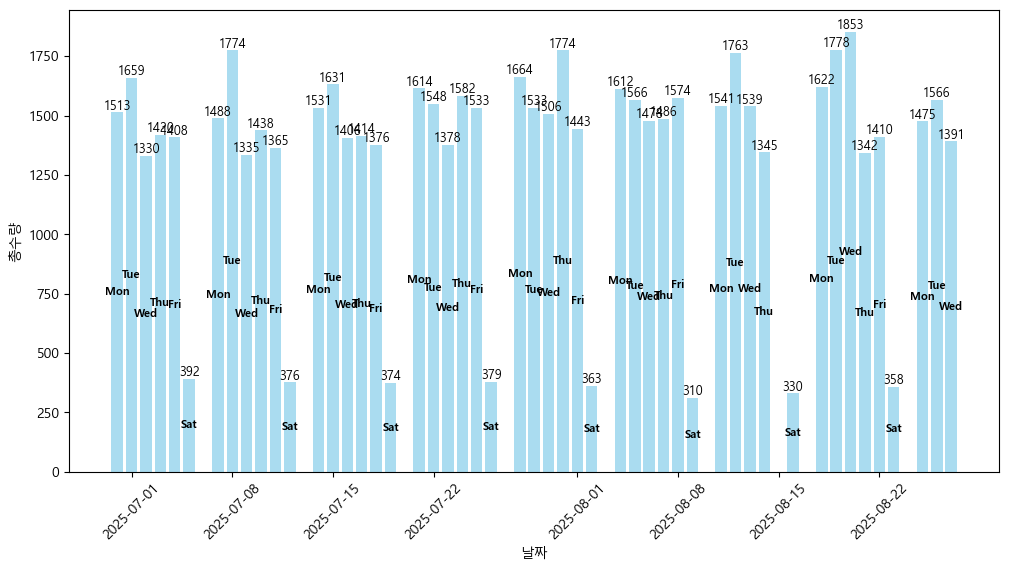

In [6]:
fig, ax1 = plt.subplots(figsize=(12,6))

bars = ax1.bar(df['delivery_date'], df['total_quantity'], alpha=0.7, color = 'skyblue', label="날짜별 수량")

for i, (bar, quantity, is_holiday, day) in enumerate(zip(bars, df['total_quantity'], df['is_holiday'], df['day'])):
    height = bar.get_height()
    
    # 막대 위에 수량 표시
    text = f'{int(height)}'
    if is_holiday:
        text += '\n(H)'  # 공휴일은 H로 표시
    
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             text,
             ha='center', va='bottom', fontsize=9)
    
    # 영어 요일을 줄임말로 변환
    day_short = day[:3]  # Monday -> Mon, Friday -> Fri
    
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             day_short,
             ha='center', va='center', fontsize=8, 
             color='black', weight='bold')

ax1.set_xlabel('날짜')
ax1.set_ylabel('총수량')
ax1.tick_params(axis='x', rotation=45)

In [7]:
# 요일 순서 고정정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_avg = df.groupby('day').agg({
    'total_quantity': 'mean',
    'total_amount': 'mean',
}).round(2)

daily_avg.columns = ['평균_수량', '평균_금액']
daily_avg = daily_avg.reindex(weekday_order)

print("요일별 평균")
print(daily_avg)

요일별 평균
             평균_수량        평균_금액
day                            
Monday     1562.22  13163155.56
Tuesday    1646.44  13912622.22
Wednesday  1468.44  12031277.78
Thursday   1475.12  12010525.00
Friday     1444.14  12176800.00
Saturday    360.25   3170200.00
Sunday         NaN          NaN


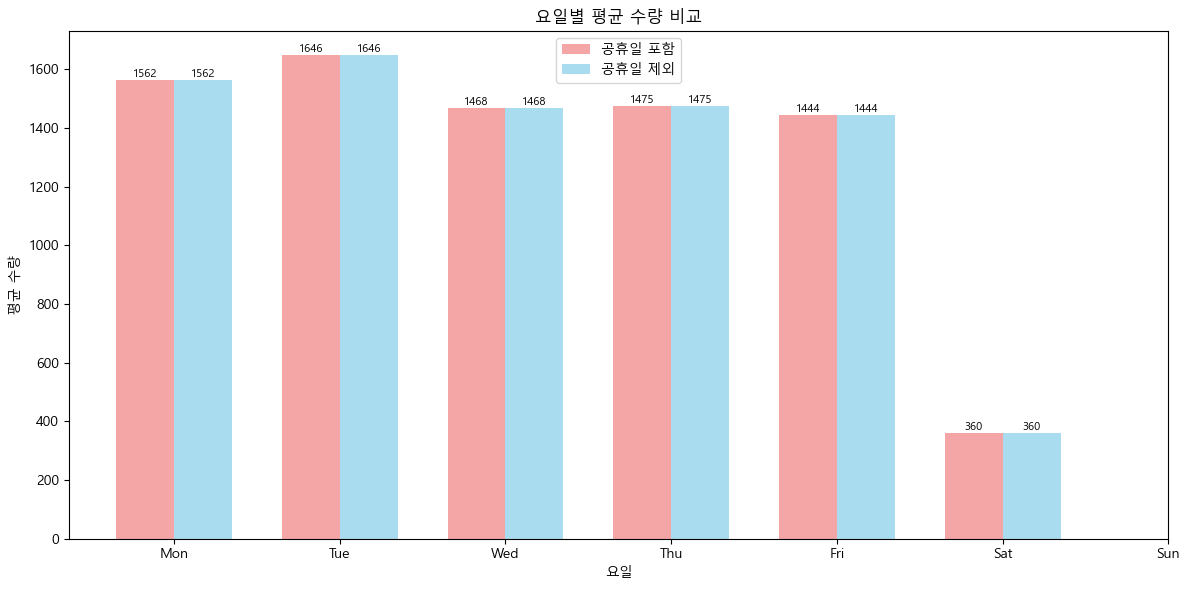

In [8]:
# 현재 공휴일에는 delivery_date가 없어서 공휴일 포함과 제외가 동일하게 공휴일을 담고 있지 않음

# 전체 데이터 평균
all_days_avg = df.groupby('day')['total_quantity'].mean().reindex(weekday_order)

# 공휴일 제외 평균
business_days_avg = df[df['is_holiday'] == False].groupby('day')['total_quantity'].mean().reindex(weekday_order)

# 차트 그리기
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(weekday_order))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], all_days_avg, width, 
               label='공휴일 포함', alpha=0.7, color='lightcoral')
bars2 = ax.bar([i + width/2 for i in x], business_days_avg, width,
               label='공휴일 제외', alpha=0.7, color='skyblue')

ax.set_xlabel('요일')
ax.set_ylabel('평균 수량')
ax.set_title('요일별 평균 수량 비교')
ax.set_xticks(x)
ax.set_xticklabels([day[:3] for day in weekday_order])
ax.legend()

# 막대 위에 수치 표시
for bar in bars1:
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
df = get_total_quantity('2025-06-30', current_date)

df['date'] = pd.to_datetime(df['delivery_date'])
df['day'] = df['date'].dt.day_name()

years = pd.to_datetime(df['delivery_date'], errors='coerce').dt.year.dropna().astype(int).unique()
kr_holidays = holidays.KR(years=years, observed=True)

df['is_holiday'] = df['date'].apply(lambda x: x in kr_holidays)

selected_products = ["가정식 도시락", "가정식 도시락 곱빼기", "가정식 도시락(석식)", "프레시밀"]
df = df[df['product_name'].isin(selected_products)]

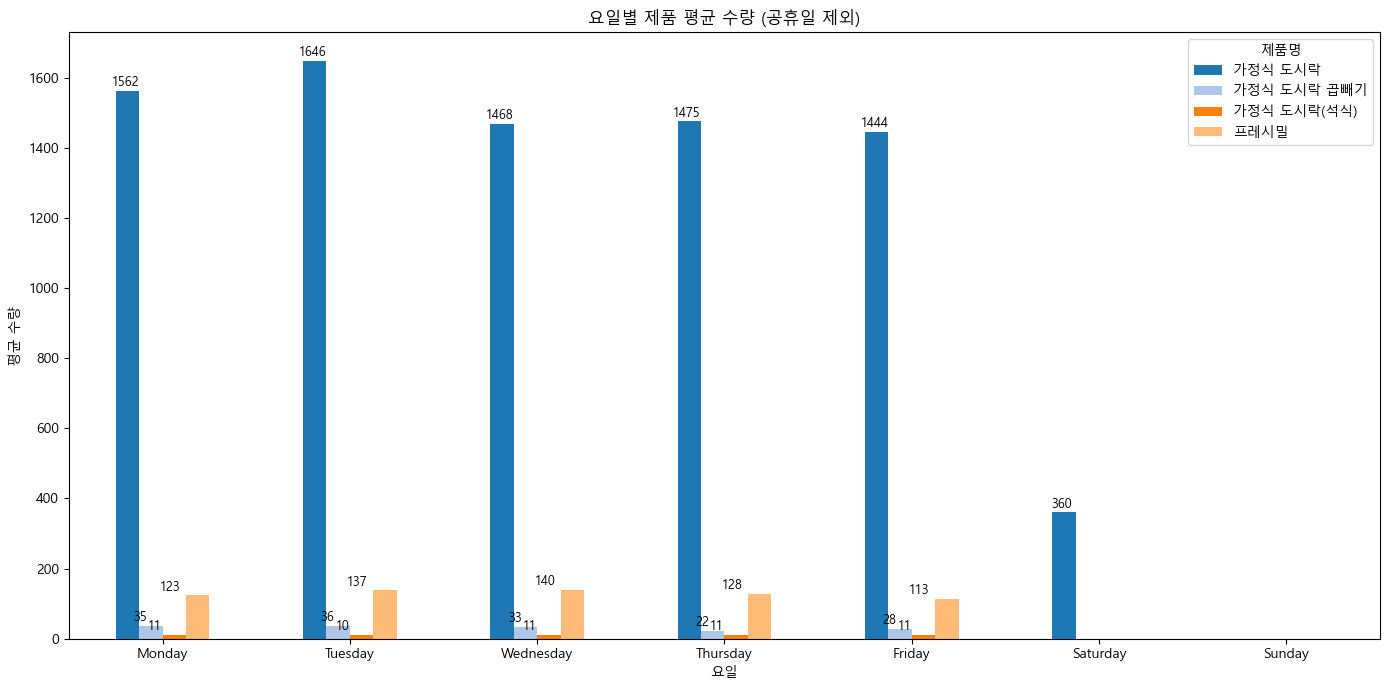

In [10]:
# 요일별 평균 수량 계산
df_weekday_avg = (
    df.groupby(['product_name', 'day'])['total_quantity']
    .mean()
    .reset_index()
)

# 3. pivot: 행=요일, 열=제품명
df_pivot = df_weekday_avg.pivot(index='day', columns='product_name', values='total_quantity')

# 4. 요일 순서 정렬
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_pivot = df_pivot.reindex(weekday_order)

# 5. 시각화
fig, ax = plt.subplots(figsize=(14,7))
colors = plt.cm.tab20.colors  # 여러 제품 색상 자동 할당
df_pivot.plot(kind='bar', ax=ax, color=colors)

ax.set_ylabel("평균 수량")
ax.set_xlabel("요일")
ax.set_title("요일별 제품 평균 수량 (공휴일 제외)")
plt.xticks(rotation=0)

# 6. 막대 위에 수량 표시
for i, weekday in enumerate(df_pivot.index):
    for j, product in enumerate(df_pivot.columns):
        value = df_pivot.loc[weekday, product]
        if not pd.isna(value):
            ax.text(i + j*0.08 - 0.2, value + 5,  # x 위치 조정, y는 막대 위 +5
                    f"{int(value)}",
                    ha='center', va='bottom', fontsize=9)

plt.legend(title="제품명")
plt.tight_layout()
plt.show()

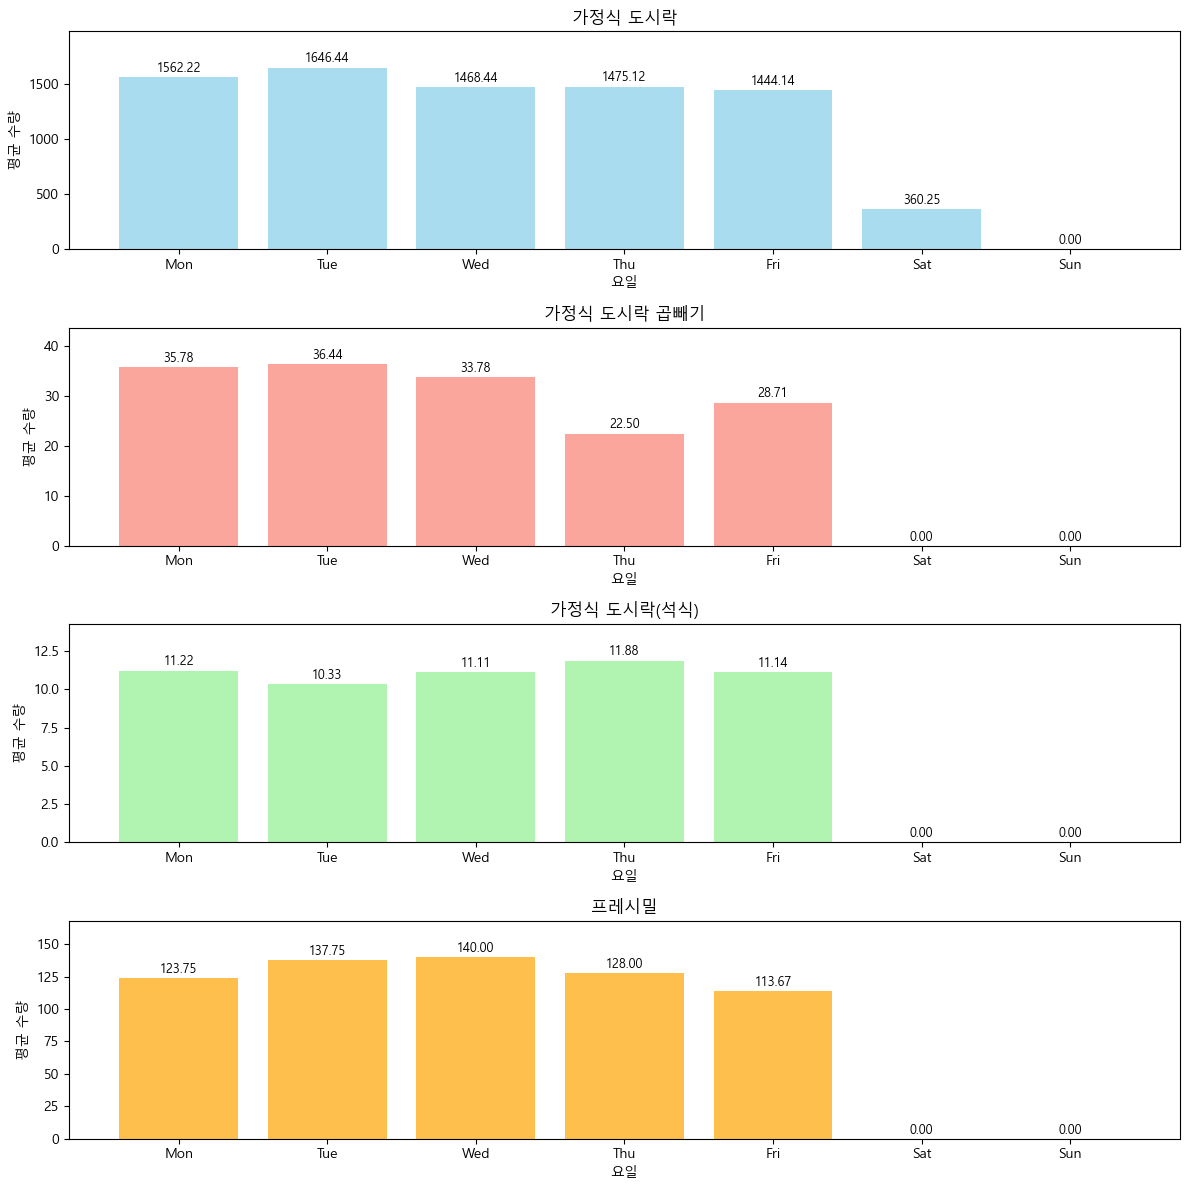

In [11]:
# subplot 생성
n_plots = len(selected_products)
fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots*3))
if n_plots == 1:
    axes = [axes]

# 색상 지정
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink']

# y축 최대값 계산 (모든 subplot 동일 y축)
ymax = df_pivot[selected_products].max().max() * 1.1

# 요일명을 3자리로 변환하는 함수
def format_weekday(day_name):
    day_mapping = {
        'Monday': 'Mon',
        'Tuesday': 'Tue', 
        'Wednesday': 'Wed',
        'Thursday': 'Thu',
        'Friday': 'Fri',
        'Saturday': 'Sat',
        'Sunday': 'Sun'
    }
    return day_mapping.get(day_name, str(day_name)[:3])

# 요일 라벨 생성 (df_pivot.index의 실제 값 사용)
weekday_labels = [format_weekday(str(day)) for day in df_pivot.index]

for i, product in enumerate(selected_products):
    ax = axes[i]
    values = df_pivot[product].fillna(0)  # NaN은 0으로 처리
    bars = ax.bar(df_pivot.index, values, color=colors[i % len(colors)], alpha=0.7)

    ax.set_ylabel("평균 수량")
    ax.set_title(product)
    
    # 각 제품별 최대값 기준으로 y축 설정
    ymax = values.max() * 1.2
    ax.set_ylim(0, ymax)  # y축 동일
    
    # x축 라벨을 3자리 요일명으로 설정
    ax.set_xticks(df_pivot.index)
    ax.set_xticklabels(weekday_labels, rotation=0)
    ax.set_xlabel("요일")

    # 막대 위에 수치 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + ymax*0.01,  # 약간 위로 올림
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

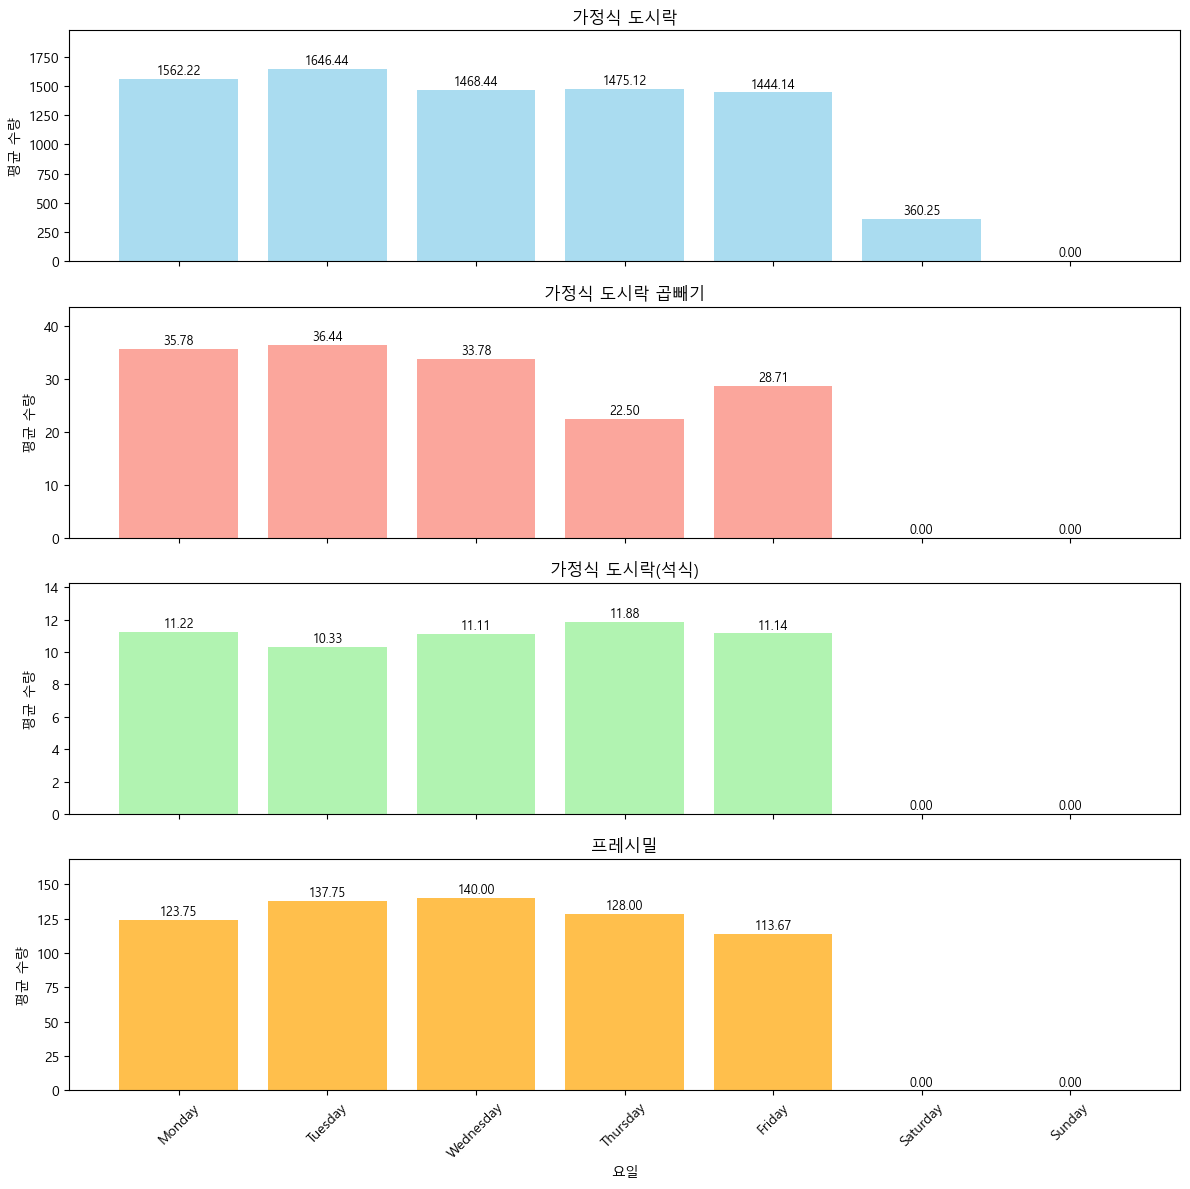

In [12]:
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink']

# subplot 생성
fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots*3), sharex=True)

for i, product in enumerate(selected_products):
    ax = axes[i]
    values = df_pivot[product].fillna(0)  # NaN은 0으로 처리
    bars = ax.bar(df_pivot.index, values, color=colors[i % len(colors)], alpha=0.7)

    ax.set_ylabel("평균 수량")
    ax.set_title(product)
    
    # 제품별 자동 y축 스케일링
    ax.set_ylim(0, values.max()*1.2)

    # 막대 위에 소숫점 둘째 자리까지 수치 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + values.max()*0.01,  # 약간 위로 올림
            f"{height:.2f}",  # 소숫점 둘째 자리까지 표시
            ha='center',
            va='bottom',
            fontsize=9
        )

axes[-1].set_xlabel("요일")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
def get_order_summary(start_date, end_date) :
    params = {
        'start_date': start_date,
        'end_date' : end_date
    }
    
    result_names =  ["weekday_avg", "daily_accounts", "max_accounts", "max_accounts_duplication", "min_accounts", "min_accounts_no_sat", "monthly_avg", 'weekly_avg']
    
    query = """
        CALL order_service.get_order_summary(%(start_date)s, %(end_date)s)
    """

    return get_db_order_summary(query, params, result_names)

result_set = get_order_summary('2025-01-01', current_date)

In [14]:
print(result_set['weekday_avg'])

  day_of_week avg_accounts_per_day
0      Monday               213.76
1     Tuesday               232.55
2   Wednesday               216.09
3    Thursday               215.33
4      Friday               211.15
5    Saturday                36.61


In [15]:
print(result_set['daily_accounts'])

    delivery_date day_of_week  account_count
0      2025-01-02    Thursday            184
1      2025-01-03      Friday            184
2      2025-01-04    Saturday             34
3      2025-01-06      Monday            191
4      2025-01-07     Tuesday            208
..            ...         ...            ...
193    2025-08-22      Friday            275
194    2025-08-23    Saturday             42
195    2025-08-25      Monday            264
196    2025-08-26     Tuesday            304
197    2025-08-27   Wednesday            270

[198 rows x 3 columns]


In [16]:
print(result_set['max_accounts'])

  delivery_date day_of_week  account_count
0    2025-07-15     Tuesday            310


In [17]:
print(result_set['min_accounts'])

  delivery_date day_of_week  account_count
0    2025-05-31    Saturday              1


In [18]:
print(result_set["min_accounts_no_sat"])

  delivery_date day_of_week  account_count
0    2025-06-06      Friday              1


In [19]:
print(result_set['max_accounts_duplication'])

  delivery_date day_of_week  account_count
0    2025-07-15     Tuesday            310
1    2025-08-19     Tuesday            310


In [20]:
print(result_set['monthly_avg'])

     month avg_accounts_per_month
0  2025-01                 156.70
1  2025-02                 167.67
2  2025-03                 170.60
3  2025-04                 171.50
4  2025-05                 174.12
5  2025-06                 191.52
6  2025-07                 235.56
7  2025-08                 232.45


In [21]:
print(result_set['weekly_avg'])

    year  week avg_accounts_per_week
0   2025     1                134.00
1   2025     2                167.83
2   2025     3                169.33
3   2025     4                166.00
4   2025     5                 71.67
5   2025     6                166.50
6   2025     7                164.33
7   2025     8                166.00
8   2025     9                202.20
9   2025    10                148.67
10  2025    11                178.33
11  2025    12                174.00
12  2025    13                177.33
13  2025    14                169.50
14  2025    15                167.67
15  2025    16                168.17
16  2025    17                169.50
17  2025    18                151.50
18  2025    19                145.60
19  2025    20                190.17
20  2025    21                198.67
21  2025    22                193.67
22  2025    23                132.50
23  2025    24                201.00
24  2025    25                210.50
25  2025    26                212.00
2

310 1


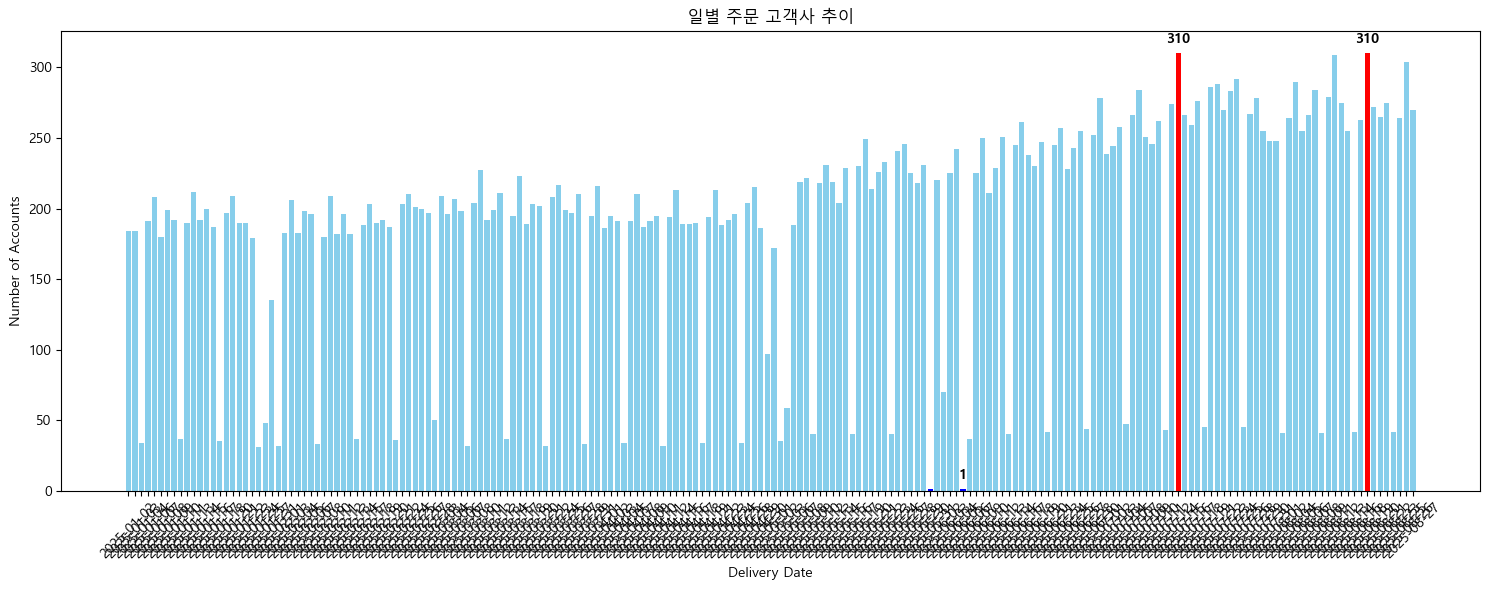

In [22]:
df = result_set['daily_accounts']

max_val = df['account_count'].max()
min_val = df[df['day_of_week'] != 'Saturday']['account_count'].min()

print(max_val, min_val)

# 색상 설정
colors = ['red' if x == max_val else 'blue' if x == min_val else 'skyblue' for x in df['account_count']]

# x축 인덱스
x = range(len(df))

plt.figure(figsize=(15,6))
plt.bar(x, df['account_count'], color=colors)

# 최대값/최소값 라벨 표시
for idx, row in df.iterrows():
    if row['account_count'] == max_val or (row['account_count'] == min_val and row['day_of_week'] != 'Saturday'):
        plt.text(idx, row['account_count'] + 5, str(row['account_count']), ha='center', va='bottom', fontweight='bold')

# x축 라벨 날짜로 변경
plt.xticks(ticks=x, labels=df['delivery_date'], rotation=45)
plt.xlabel("Delivery Date")
plt.ylabel("Number of Accounts")
plt.title("일별 주문 고객사 추이")
plt.tight_layout()
plt.show()

310 1


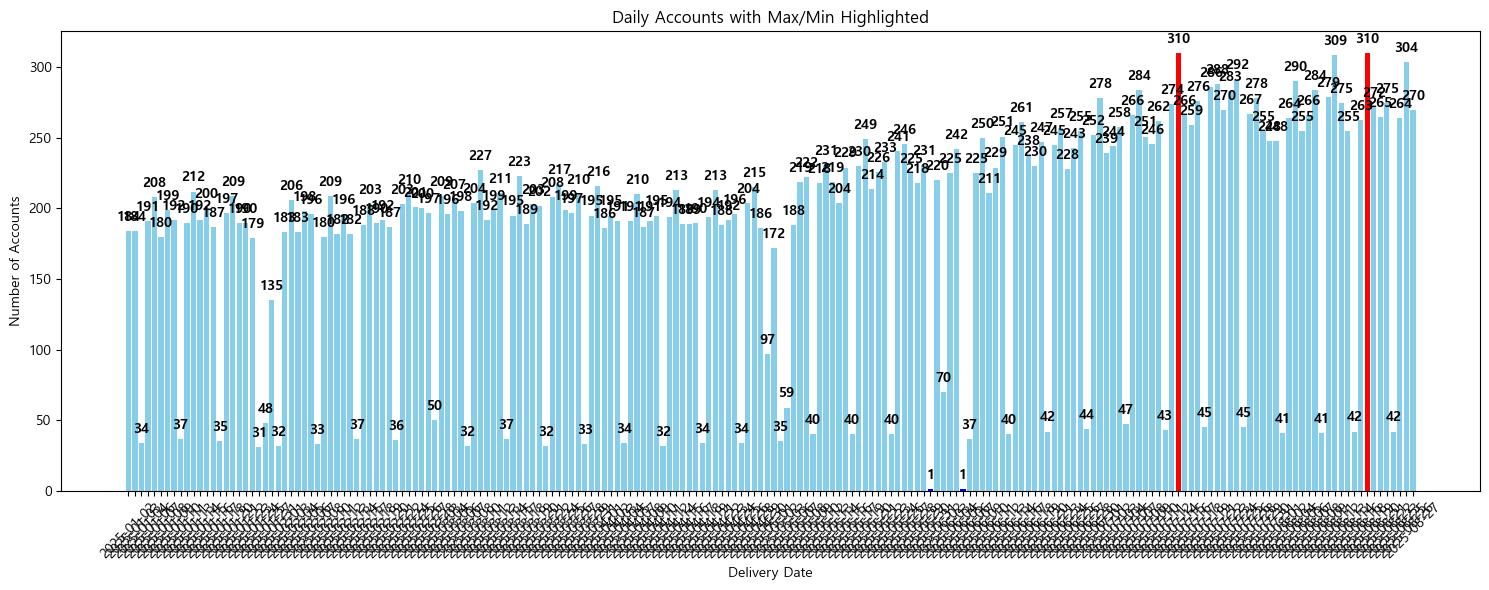

In [23]:
df = result_set['daily_accounts']

max_val = df['account_count'].max()
min_val = df[df['day_of_week'] != 'Saturday']['account_count'].min()

print(max_val, min_val)

# 색상 설정
colors = ['red' if x == max_val else 'blue' if x == min_val else 'skyblue' for x in df['account_count']]

# x축 인덱스
x = range(len(df))

plt.figure(figsize=(15,6))
plt.bar(x, df['account_count'], color=colors)

# 모든 막대 위에 수치 표시
for idx, row in df.iterrows():
    plt.text(idx, row['account_count'] + 5, str(row['account_count']), 
             ha='center', va='bottom', fontweight='bold')

# x축 라벨 날짜로 변경
plt.xticks(ticks=x, labels=df['delivery_date'], rotation=45)
plt.xlabel("Delivery Date")
plt.ylabel("Number of Accounts")
plt.title("Daily Accounts with Max/Min Highlighted")
plt.tight_layout()
plt.show()

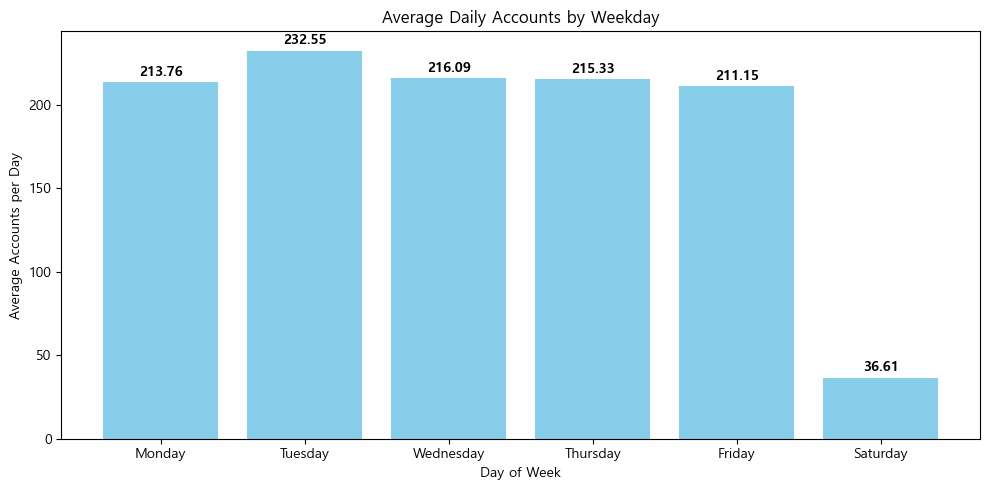

In [24]:
df = result_set['weekday_avg']

# 요일 순서 지정
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=weekday_order, ordered=True)
df = df.sort_values('day_of_week')

# 막대차트
plt.figure(figsize=(10,5))
plt.bar(df['day_of_week'], df['avg_accounts_per_day'], color='skyblue')

# 값 라벨 표시
for idx, row in df.iterrows():
    plt.text(row['day_of_week'], row['avg_accounts_per_day'] + 2, f"{row['avg_accounts_per_day']:.2f}", 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel("Day of Week")
plt.ylabel("Average Accounts per Day")
plt.title("Average Daily Accounts by Weekday")
plt.tight_layout()
plt.show()

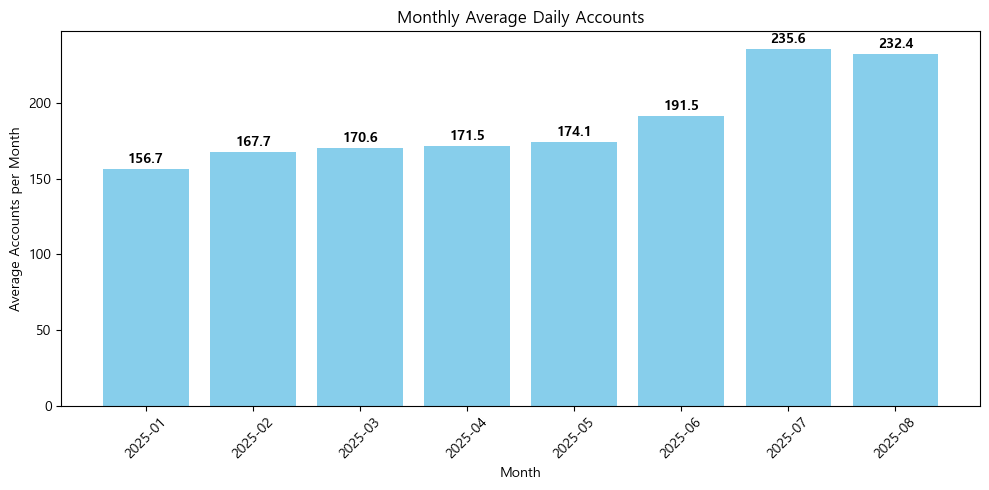

In [25]:
# 월별 평균 DataFrame 가져오기
df = result_set['monthly_avg']

# 막대차트 그리기
plt.figure(figsize=(10,5))
plt.bar(df['month'], df['avg_accounts_per_month'], color='skyblue')

# 값 라벨 표시
for idx, row in df.iterrows():
    plt.text(row['month'], row['avg_accounts_per_month'] + 2, f"{row['avg_accounts_per_month']:.1f}", 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel("Month")
plt.ylabel("Average Accounts per Month")
plt.title("Monthly Average Daily Accounts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

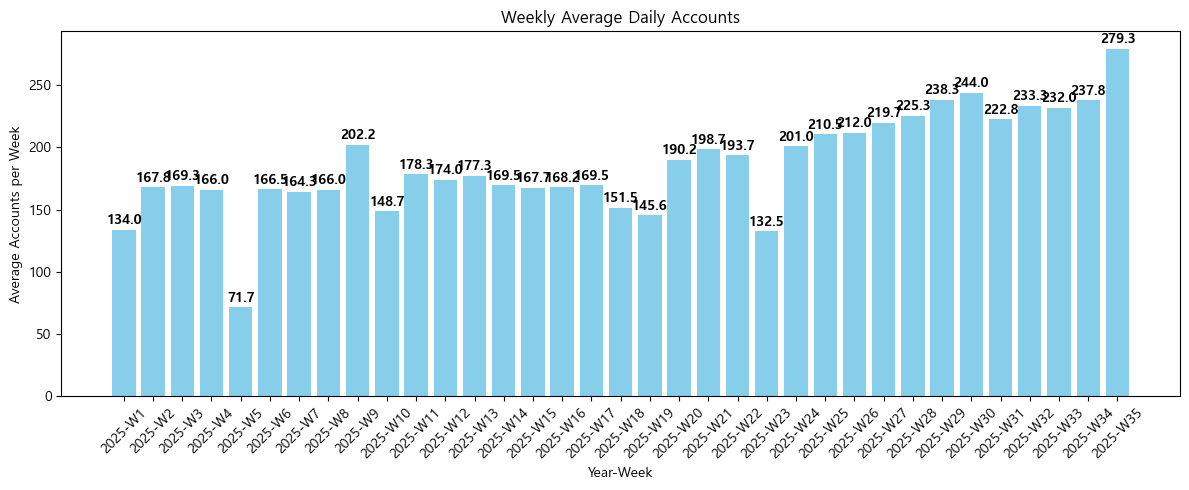

In [26]:
# 주별 평균 DataFrame 가져오기
df = result_set['weekly_avg']

# 주차 기준 문자열 생성
df['year_week'] = df['year'].astype(str) + '-W' + df['week'].astype(str)

plt.figure(figsize=(12,5))
plt.bar(df['year_week'], df['avg_accounts_per_week'], color='skyblue')

# 값 라벨 표시
for idx, row in df.iterrows():
    plt.text(idx, row['avg_accounts_per_week'] + 2, f"{row['avg_accounts_per_week']:.1f}",
             ha='center', va='bottom', fontweight='bold')

plt.xlabel("Year-Week")
plt.ylabel("Average Accounts per Week")
plt.title("Weekly Average Daily Accounts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

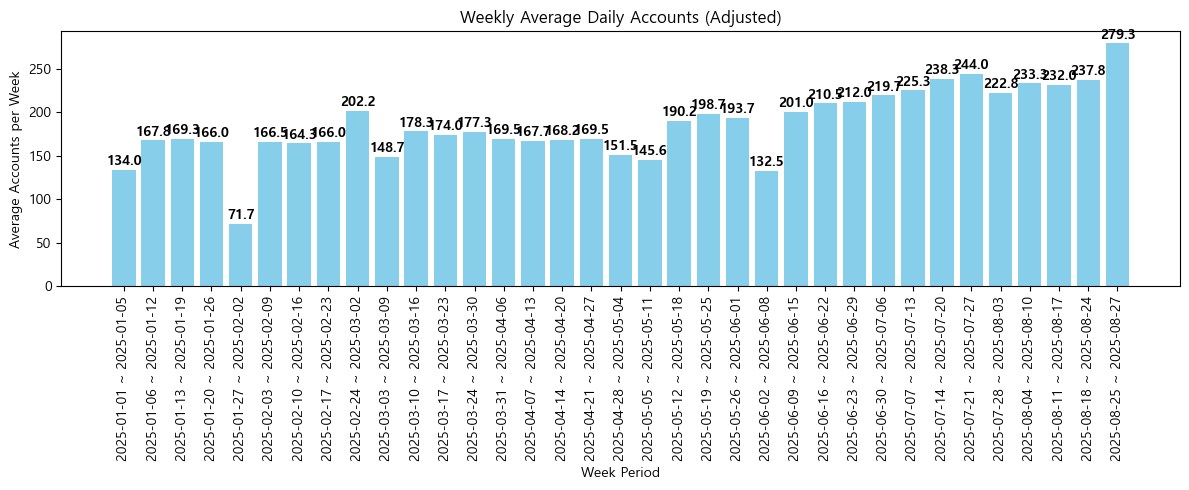

In [27]:
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime(current_date)

# 주 시작일, 종료일 계산
df['week_start'] = df.apply(lambda x: pd.to_datetime(f"{x['year']}-W{x['week']}-1", format="%G-W%V-%u"), axis=1)
df['week_end']   = df['week_start'] + pd.Timedelta(days=6)

# 실제 데이터 범위 내로 제한
df['week_start'] = df['week_start'].apply(lambda d: max(d, start_date))
df['week_end']   = df['week_end'].apply(lambda d: min(d, end_date))

# 주차 범위 문자열 생성
df['week_range'] = df['week_start'].dt.strftime('%Y-%m-%d') + ' ~ ' + df['week_end'].dt.strftime('%Y-%m-%d')

# 시각화
plt.figure(figsize=(12,5))
plt.bar(df['week_range'], df['avg_accounts_per_week'], color='skyblue')

# 값 라벨 표시
for idx, row in df.iterrows():
    plt.text(idx, row['avg_accounts_per_week'] + 2, f"{row['avg_accounts_per_week']:.1f}",
             ha='center', va='bottom', fontweight='bold')

plt.xlabel("Week Period")
plt.ylabel("Average Accounts per Week")
plt.title("Weekly Average Daily Accounts (Adjusted)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
# 프레시밀 평균

# 조회할 product_id 지정
product_ids = 23
start_date = "2025-08-01"
end_date = current_date

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_product(%s,%s,%s);"
params = (product_ids, start_date, end_date)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result.tail(5))

    account_name day_of_week  avg_quantity
192        TOTAL      Monday        170.29
193        TOTAL     Tuesday        199.77
194        TOTAL   Wednesday        199.23
195        TOTAL    Thursday        108.16
196        TOTAL      Friday        128.79


In [29]:
# 가정식 평균

# 조회할 product_id 지정
product_ids = 4
start_date = "2025-08-01"
end_date = current_date

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_product(%s,%s,%s);"
params = (product_ids, start_date, end_date)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result.tail(6))

     account_name day_of_week  avg_quantity
1627        TOTAL      Friday       1473.47
1628        TOTAL      Monday       1622.06
1629        TOTAL     Tuesday       1676.06
1630        TOTAL   Wednesday       1508.41
1631        TOTAL    Thursday       1443.00
1632        TOTAL    Saturday        370.41


In [34]:
# 샐러위치, 샐러드밀 + 프레시밀 평균

# 조회할 product_id 지정
product_ids = "1,8,23"
start_date = "2025-08-01"
end_date = current_date

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_product(%s,%s,%s);"
params = (product_ids, start_date, end_date)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result.tail(6))

     account_name day_of_week  avg_quantity
1321        TOTAL      Friday        520.72
1322        TOTAL      Monday        538.95
1323        TOTAL     Tuesday        612.91
1324        TOTAL   Wednesday        582.40
1325        TOTAL    Thursday        568.09
1326        TOTAL    Saturday          1.00


In [43]:
# 조회할 product_id 지정
product_ids = "4"
start_date = "2025-08-01"
end_date = current_date

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_product(%s,%s,%s);"
params = (product_ids, start_date, end_date)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result)

     account_name day_of_week  avg_quantity
0        (주)엠피엘제이      Friday          2.75
1        (주)엠피엘제이     Tuesday          4.50
2        (주)엠피엘제이   Wednesday          2.75
3        (주)엠피엘제이      Monday          4.50
4        (주)엠피엘제이    Thursday          3.67
...           ...         ...           ...
1628        TOTAL      Monday       1622.06
1629        TOTAL     Tuesday       1676.06
1630        TOTAL   Wednesday       1508.41
1631        TOTAL    Thursday       1443.00
1632        TOTAL    Saturday        370.41

[1633 rows x 3 columns]


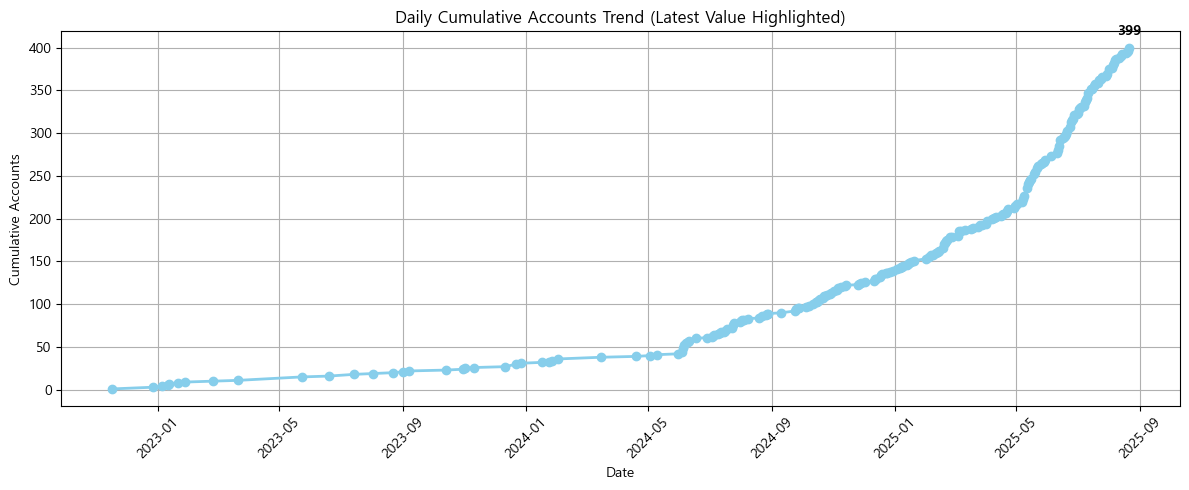

In [68]:
type_list = "business,regular"

# 프로시저 호출 쿼리
query = "CALL order_service.get_account_growth_by_type(%s);"
params = (type_list,)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
# print(df_result)


# 시각화

# 라인 차트
# plt.figure(figsize=(12, 5))

# plt.plot(df_result['created_date'], df_result['cumulative_accounts'], marker='o', color='skyblue', linewidth=2)

# # 값 라벨 표시 (선 위에 값 표시)
# # for x, y in zip(df_result['created_date'], df_result['cumulative_accounts']):
# #     plt.text(x, y + 1, f"{y:.0f}", ha='center', va='bottom', fontsize=9)

# plt.xlabel("Date")
# plt.ylabel("Cumulative Accounts")
# plt.title("Daily Cumulative Accounts Trend")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# 스텝 차트
# plt.figure(figsize=(12, 5))

# plt.step(df_result['created_date'], df_result['cumulative_accounts'], where='post', color='orange', linewidth=2)
# plt.scatter(df_result['created_date'], df_result['cumulative_accounts'], color='orange')

# plt.xlabel("Date")
# plt.ylabel("Cumulative Accounts")
# plt.title("Daily Cumulative Accounts (Step Chart)")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# 가장 최신 고객사 수만 표시시
# 날짜 정렬
df_result = df_result.sort_values('created_date')

plt.figure(figsize=(12, 5))

# 라인 차트
plt.plot(df_result['created_date'], df_result['cumulative_accounts'], marker='o', color='skyblue', linewidth=2)

# 최신 값 라벨 (x축은 날짜, y축은 누적값)
last_row = df_result.iloc[-1]

# 일정한 오프셋을 위해 전체 값의 3% 정도 더함
offset = df_result['cumulative_accounts'].max() * 0.03

plt.text(
    last_row['created_date'], 
    last_row['cumulative_accounts'] + offset,
    f"{last_row['cumulative_accounts']:.0f}",
    ha='center', va='bottom', fontsize=10, fontweight='bold'
)

plt.xlabel("Date")
plt.ylabel("Cumulative Accounts")
plt.title("Daily Cumulative Accounts Trend (Latest Value Highlighted)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
start_date = "2025-08-04"
# end_date = current_date
end_date = "2025-08-22"

# 프로시저 호출 쿼리
query = "CALL order_service.get_product_weekday_summary_by_period(%s,%s);"
params = (start_date, end_date)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result)

    product_name day_of_week  total_avg_quantity  active_account_count
0        가정식 도시락           월           1570.2976                   300
1        가정식 도시락           화           1660.7753                   323
2        가정식 도시락           수           1482.0458                   296
3        가정식 도시락           목           1418.6875                   299
4        가정식 도시락           금           1423.3453                   287
5        가정식 도시락           토            348.5000                    48
6    가정식 도시락 곱빼기           월             27.5334                     3
7    가정식 도시락 곱빼기           화             27.8333                     3
8    가정식 도시락 곱빼기           수             27.5000                     3
9    가정식 도시락 곱빼기           목             15.3333                     2
10   가정식 도시락 곱빼기           금             22.2500                     3
11   가정식 도시락(석식)           월             12.0000                     1
12   가정식 도시락(석식)           화             11.3333                     1
13   가

In [85]:
start_date = "2025-08-04"
end_date = "2025-08-22"
types = "business,regular"
product_ids = "4"

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_products(%s,%s,%s,%s);"
params = (start_date, end_date, product_ids, types)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result.tail(6))

      account_id account_name product_name day_of_week  avg_quantity
1553         NaN        TOTAL      가정식 도시락           월       1570.35
1554         NaN        TOTAL      가정식 도시락           화       1660.81
1555         NaN        TOTAL      가정식 도시락           수       1482.03
1556         NaN        TOTAL      가정식 도시락           목       1418.70
1557         NaN        TOTAL      가정식 도시락           금       1423.35
1558         NaN        TOTAL      가정식 도시락           토        348.50


In [ ]:
start_date = "2025-08-04"
end_date = "2025-08-22"
types = "business,regular"
product_ids = "4"

# 프로시저 호출 쿼리
query = "CALL order_service.get_avg_quantity_by_products(%s,%s,%s,%s);"
params = (start_date, end_date, product_ids, types)

# query_db 함수로 실행
df_result = query_db(query, params=params)

# 결과 출력
print(df_result.tail(15))

   account_id   account_name product_name day_of_week  avg_quantity
0      1625.0  성수점B_김명관님3254      가정식 도시락           금           2.0
1         NaN          TOTAL      가정식 도시락           금           2.0
